# Imports

In [4]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    AddChanneld, 
    CenterSpatialCropd, 
    Compose, 
    Lambdad, 
    LoadImaged, 
    Resized, 
    ScaleIntensityd
)
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval 

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

# Set seeds and configs

In [5]:
# Initialize Configuration
config = {
    'batch_size': 4,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

# Load the data

In [8]:
# Initialize paths and states
pathBase = '/scratch1/akrami/Data_train'
csvpath_trains = ['/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/IXI_train_fold0.csv']
csvpath_val = '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/IXI_val_fold0.csv'
csvpath_test = '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/Brats21_sub_test.csv'
states = ['train', 'val', 'test']

# Initialize empty dictionary and list
var_csv = {}
df_list = []

# Read training CSV files into DataFrames and concatenate them
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)
var_csv['train'] = pd.concat(df_list, ignore_index=True)

# Read validation and test CSV files into DataFrames
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)

# Update DataFrame paths and set types
for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['img_path'] = pathBase + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase + var_csv[state]['mask_path']
    
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase + var_csv[state]['seg_path']

# Initialize training, validation, and test data
data_train = Train(var_csv['train'], config)
data_val = Train(var_csv['val'], config)
data_test = Eval(var_csv['test'], config)

#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


# load a train example and save a nii

tensor([66.0200, 72.5900, 20.2100, 63.4000], dtype=torch.float64)
torch.Size([4, 1, 80, 96, 80])


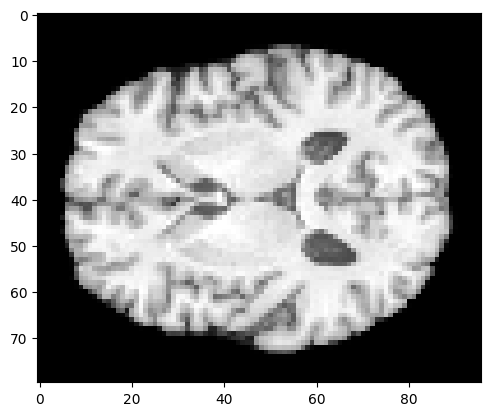

In [12]:
sub_train = next(iter(train_loader))
print(sub_train['age'])
print(sub_train['vol']['data'].size())
image_array = sub_train['vol']['data']
middle_slice_idx = image_array.size(-1) // 2
plt.imshow(image_array[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1,cmap='gray')

In [17]:
import nibabel as nib
image_data =image_array[0][0].squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, '/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii')

Error: No such file or no access: '/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii'


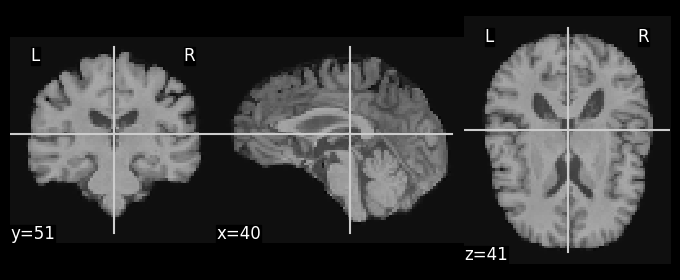

In [18]:
from nilearn.plotting import plot_anat
import nibabel as nib

def print_nifti_shape(file_path):
    try:
        # Load the NIfTI file
        nifti_img = nib.load(file_path)

        # Get the shape of the NIfTI data array
        data_shape = nifti_img.get_fdata().shape

        # Print the shape
        print(f"Shape of the NIfTI file '{file_path}': {data_shape}")
    except Exception as e:
        print(f"Error: {e}")

plot_anat("/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii")
# Replace 'your_nifti_file.nii' with the actual path to your NIfTI file
nifti_file_path = "/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii''/project/ajoshi_27/akrami//3D_lesion_DF/results/nii/train_image_0.5.nii"
print_nifti_shape(nifti_file_path)


# Load a test subject and denoise

dict_keys(['vol', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([    nan, 48.8250,     nan,     nan], dtype=torch.float64)
torch.Size([4, 1, 160, 192, 160])


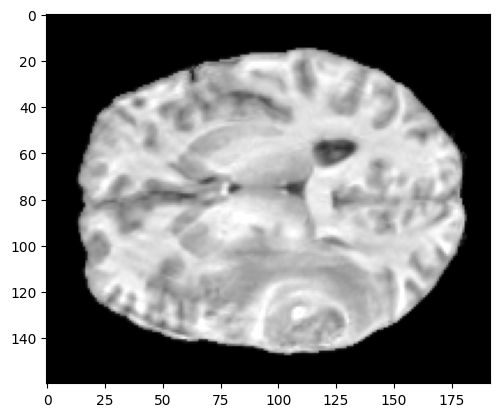

In [32]:
sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])
print(sub_test['vol']['data'].size())
image_array = sub_test['vol']['data']
middle_slice_idx = image_array.size(-1) // 2
plt.imshow(image_array[0][0][:,:,80].squeeze().cpu().numpy(), vmin=0, vmax=1,cmap='gray')

torch.Size([4, 1, 160, 192, 160])


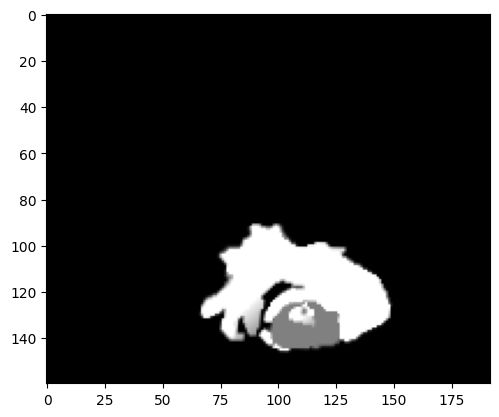

In [25]:

print(s['seg']['data'].size())
image_array_sclice= s['seg']['data'][0][0][:,:,middle_slice_idx].squeeze().cpu().numpy()
plt.imshow(image_array_sclice, cmap='gray')

In [ ]:
## load the model

In [12]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 4 GPUs!


In [13]:
# specify your model filename
model_filename = '/acmenas/hakrami/3D_lesion_DF/models/small_net/model_epoch424.pt'

# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
 

## Sampling Brain Image

In order to sample the brain images, we need to pass the model an image containing just noise and use it to remove the noise of the image iteratively. For that, we will use the `.sample()` function of the `inferer`.

In [14]:

noise = torch.randn((1, 1, 160,192, 160))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


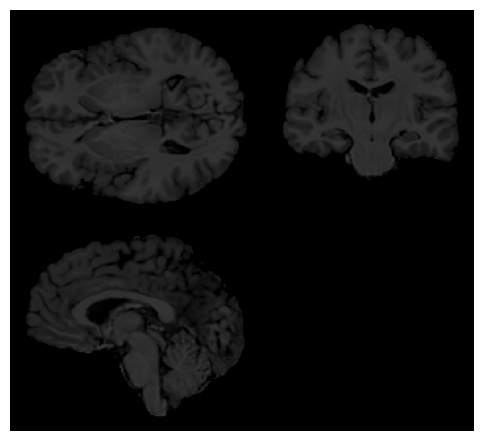

In [15]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 80].cpu(), np.flipud(image[0, 0, :, 96, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 80, :, :].cpu().T), np.zeros((160, 160))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [16]:

import nibabel as nib
image_data = image.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_image_2.nii')

Shape of the NIfTI file 'test_image_2.nii': (160, 192, 160)


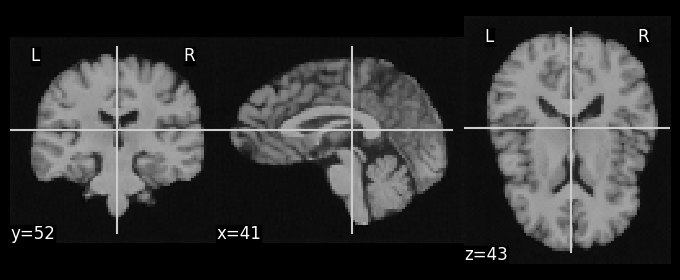

In [18]:
from nilearn.plotting import plot_anat
import nibabel as nib

def print_nifti_shape(file_path):
    try:
        # Load the NIfTI file
        nifti_img = nib.load(file_path)

        # Get the shape of the NIfTI data array
        data_shape = nifti_img.get_fdata().shape

        # Print the shape
        print(f"Shape of the NIfTI file '{file_path}': {data_shape}")
    except Exception as e:
        print(f"Error: {e}")

plot_anat("test_image.nii")
# Replace 'your_nifti_file.nii' with the actual path to your NIfTI file
nifti_file_path = "test_image_2.nii"
print_nifti_shape(nifti_file_path)


## Generate noise

In [28]:
noise =torch.randn_like(image_array)
#for i in range(1000):
#noisy_img = scheduler.add_noise(original_samples=noisy_img, noise=noise, timesteps=torch.tensor(i))
noisy_img_v2 = scheduler.add_noise(original_samples=image_array, noise=noise, timesteps=torch.tensor(500))

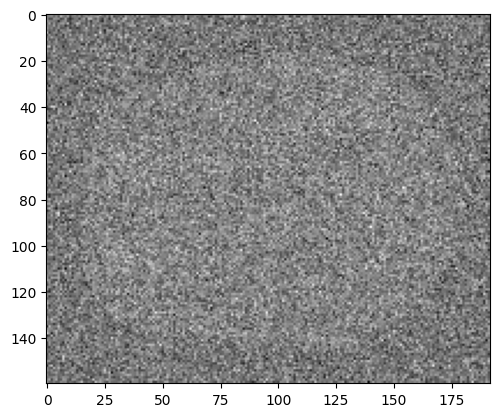

In [29]:

plt.imshow(noisy_img_v2[0][0][:,:,80].squeeze().cpu().numpy(), cmap='gray')

In [30]:
noise = noisy_img_v2[0:1,:,:,:,:].to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image_xx = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


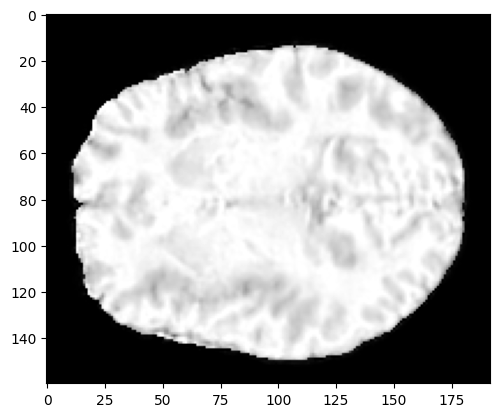

In [35]:


# Now when displaying any image:
#plt.imshow(diff_image[0][0][:,:,80].squeeze().cpu().numpy(), cmap='gray', vmin=global_vmin, vmax=global_vmax)
plt.imshow(image_xx[0][0][:,:,80].squeeze().cpu().numpy(),vmin=0, vmax=1, cmap='gray')

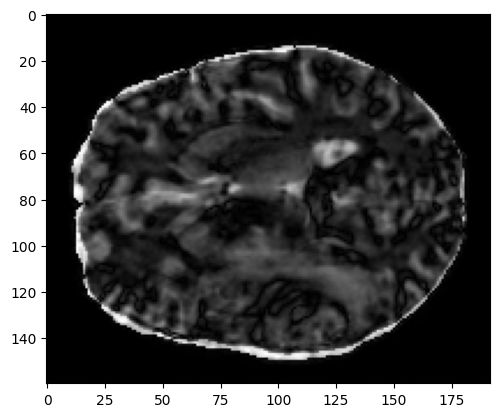

In [36]:
diff_image = torch.abs(image_xx.to(device)-image_array[0:1,:,:,:,:].to(device))
plt.imshow(diff_image[0][0][:,:,80].squeeze().cpu().numpy(),vmin=0, vmax=1, cmap='gray')

In [37]:
import nibabel as nib
image_data = image_xx.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_brats_recon_image_2.nii')

In [38]:
import nibabel as nib
image_data = image_array.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_brats_image_2.nii')

### Sampling with Denoising Diffusion Implicit Model Scheduler

Recent papers have proposed different ways to improve the sampling speed by using fewer steps in the denoising process. In this example, we are using a `DDIMScheduler` (from [Song et al. "Denoising Diffusion Implicit Models"](https://arxiv.org/abs/2010.02502)) to reduce the original number of steps from 1000 to 250.

In [ ]:
scheduler_ddim = DDIMScheduler(
    num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195, clip_sample=False
)

scheduler_ddim.set_timesteps(num_inference_steps=250)

model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)

image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler_ddim)

In [ ]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()